In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import iirnotch, butter, filtfilt

DATA_DIR = Path("../data/ninapro/")  
FS = 100.0  # DB1 EMG sampling rate (RMS at ~100 Hz)

In [2]:
def lower_nonmeta_keys(d):
    return {k.lower(): v for k, v in d.items() if not k.startswith("__")}

def pick_key(d, name, required=True):
    name = name.lower()
    if name in d:
        return d[name]
    for k in d.keys():
        if k.lower() == name:
            return d[k]
    if required:
        raise KeyError(f"Key '{name}' not found among: {list(d.keys())}")
    return None

def read_mat(path):
    m = loadmat(path, squeeze_me=True, struct_as_record=False)
    return lower_nonmeta_keys(m)

def ensure_samples_channels(X):
    X = np.asarray(X)
    if X.ndim == 1:
        X = X[:, None]
    # heuristic: DB1 is usually (samples, channels)
    if X.shape[0] < X.shape[1] and X.shape[1] > 32:
        X = X.T
    return X.astype(np.float32)

In [3]:
mats = sorted(DATA_DIR.rglob("*.mat"))
print("Found .mat files:", len(mats))
mats[:5]

Found .mat files: 81


[PosixPath('../data/ninapro/s1/S1_A1_E1.mat'),
 PosixPath('../data/ninapro/s1/S1_A1_E2.mat'),
 PosixPath('../data/ninapro/s1/S1_A1_E3.mat'),
 PosixPath('../data/ninapro/s10/S10_A1_E1.mat'),
 PosixPath('../data/ninapro/s10/S10_A1_E2.mat')]

In [4]:
assert len(mats) > 0, "No .mat files found—check DATA_DIR"

mat = read_mat(mats[0])
emg = ensure_samples_channels(pick_key(mat, "emg"))
stimulus = np.asarray(pick_key(mat, "stimulus"), dtype=np.int32)
restimulus = np.asarray(pick_key(mat, "restimulus"), dtype=np.int32)
repetition = np.asarray(pick_key(mat, "repetition"), dtype=np.int32)
rerepetition = np.asarray(pick_key(mat, "rerepetition"), dtype=np.int32)

label = restimulus  # refined labels 
emg.shape, label.shape

((101014, 10), (101014,))

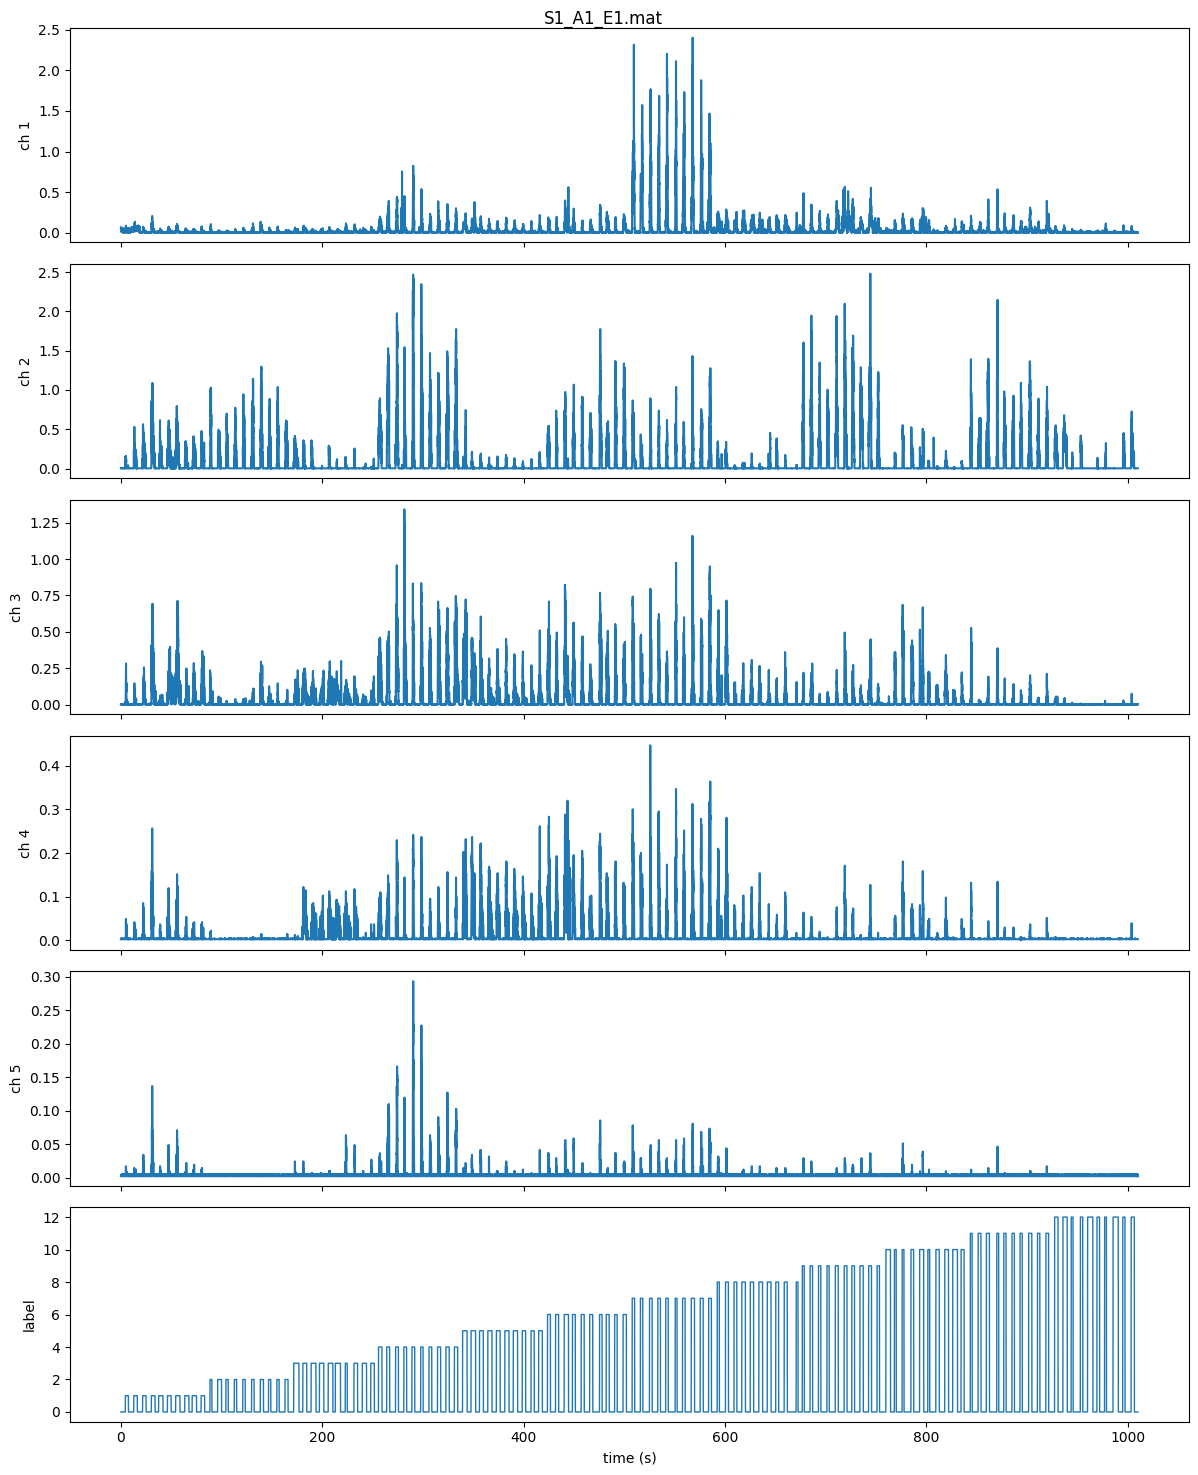

In [5]:
n = min(5, emg.shape[1])  # plot a few channels
t = np.arange(emg.shape[0]) / FS

fig, ax = plt.subplots(n+1, 1, figsize=(12, 2.5*(n+1)), sharex=True)
for i in range(n):
    ax[i].plot(t, emg[:, i])
    ax[i].set_ylabel(f"ch {i+1}")
ax[-1].plot(t, label, lw=1)
ax[-1].set_ylabel("label")
ax[-1].set_xlabel("time (s)")
fig.suptitle(mats[0].name)
plt.tight_layout()
plt.show()

In [8]:
def notch_filter(x, fs=FS, f0=50.0, q=30.0):
    b, a = iirnotch(w0=f0/(fs/2), Q=q)
    return filtfilt(b, a, x, axis=0)

def bandpass_filter(x, fs=FS, low=1.0, high=40.0, order=4):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype="band")
    return filtfilt(b, a, x, axis=0)

def rectify_and_zscore(x, eps=1e-8):
    xr = np.abs(x)
    m = xr.mean(axis=0, keepdims=True)
    s = xr.std(axis=0, keepdims=True) + eps
    return (xr - m) / s

# choose mains frequency: 50 or 60
x_filt = notch_filter(emg, fs=FS, f0=50.0)
x_filt = bandpass_filter(x_filt, fs=FS, low=1.0, high=40.0)
x_proc = rectify_and_zscore(x_filt)

x_proc.shape

(101014, 10)

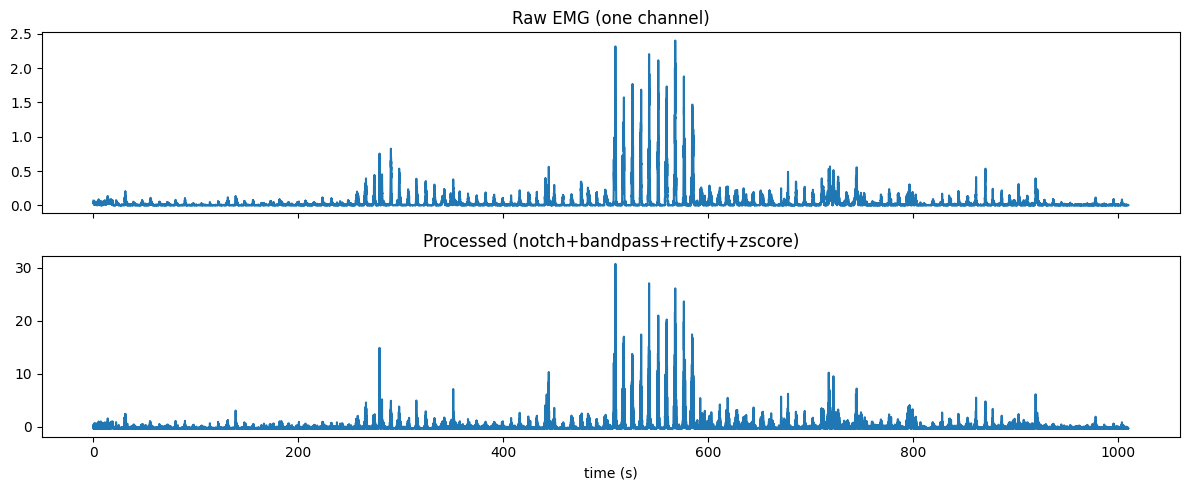

In [9]:
i = 0  # one channel to inspect
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
ax[0].plot(t, emg[:, i]); ax[0].set_title("Raw EMG (one channel)")
ax[1].plot(t, x_proc[:, i]); ax[1].set_title("Processed (notch+bandpass+rectify+zscore)")
ax[1].set_xlabel("time (s)")
plt.tight_layout(); plt.show()

In [10]:
def sliding_window(x, y, window_s=0.2, step_s=0.05, fs=FS):
    win = int(window_s * fs)
    step = int(step_s * fs)
    Xw, Yw = [], []
    for start in range(0, len(x) - win + 1, step):
        seg = x[start:start+win]
        lab = y[start:start+win]
        if lab.size == 0: 
            continue
        vals, counts = np.unique(lab, return_counts=True)
        # prefer non-zero labels if present (zero is rest, to avoid zero dominating the labels)
        idx = counts.argsort()[::-1]
        chosen = 0
        for j in idx:
            if vals[j] != 0:
                chosen = vals[j]; break
        Xw.append(seg)
        Yw.append(chosen)
    Xw = np.stack(Xw) if Xw else np.empty((0, win, x.shape[1]))
    Yw = np.array(Yw, dtype=np.int32)
    return Xw, Yw

Xw, Yw = sliding_window(x_proc, label, window_s=0.2, step_s=0.05, fs=FS)
Xw.shape, Yw.shape, np.unique(Yw)[:10]

((20199, 20, 10), (20199,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32))

In [11]:
def rms(x, axis=0): return np.sqrt((x**2).mean(axis=axis))
def mav(x, axis=0): return np.abs(x).mean(axis=axis)
def wl(x, axis=0):  return np.sum(np.abs(np.diff(x, axis=axis)), axis=axis)

# collapse each window -> feature vector (concat per-channel features)
feat = []
for w in range(Xw.shape[0]):
    seg = Xw[w]  # (win, ch)
    fvec = np.concatenate([rms(seg, axis=0), mav(seg, axis=0), wl(seg, axis=0)])
    feat.append(fvec)
feat = np.vstack(feat) if feat else np.empty((0, emg.shape[1]*3))

feat.shape, Yw.shape

((20199, 30), (20199,))

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score

if len(feat) > 0:
    Xtr, Xte, ytr, yte = train_test_split(feat, Yw, test_size=0.25, stratify=Yw, random_state=0)
    clf = Pipeline([("scaler", StandardScaler()),
                    ("lr", LogisticRegression(max_iter=200, n_jobs=None))])
    clf.fit(Xtr, ytr)
    yhat = clf.predict(Xte)
    acc = accuracy_score(yte, yhat)
    f1  = f1_score(yte, yhat, average="macro")
    print(f"Baseline — acc: {acc:.3f}  f1: {f1:.3f}")
else:
    print("No windows/features yet (check previous cells).")

Baseline — acc: 0.847  f1: 0.717
